# Imports

In [ ]:
!pip install -q git+https://github.com/tensorflow/docs

In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 10

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048

# Define path

In [ ]:
#trainfilepath = ("/content/gdrive/MyDrive/DissertationVideosSorted/train.csv")
#testfilepath = ("/content/gdrive/MyDrive/DissertationVideosSorted/test.csv")

In [ ]:
trainfilepath = ("./VideosSorted/train.csv")
testfilepath = ("./VideosSorted/test.csv")

In [ ]:
train_df = pd.read_csv(trainfilepath)
test_df = pd.read_csv(testfilepath)

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

train_df.sample(10)

Total videos for training: 735
Total videos for testing: 326


,video_name,tag
253,v_FrontCrawl_g11_c02.avi,frontcrawl
258,v_FrontCrawl_g11_c07.avi,frontcrawl
104,v_BreastStroke_g24_c01.avi,breaststroke
591,v_Skijet_g05_c02.avi,jetski
106,v_BreastStroke_g24_c03.avi,breaststroke
636,v_Skijet_g21_c03.avi,jetski
624,v_Skijet_g17_c01.avi,jetski
674,v_Surfing_g09_c01.avi,surfing
355,v_Kayaking_g11_c05.avi,kayaking
706,v_Surfing_g17_c01.avi,surfing


# Data Processing Pipeline

In [ ]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

# Feature Extractor

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten

input_shape=(IMG_SIZE, IMG_SIZE, 3)

def build_feature_extractor():
    feature_extractor = keras.models.Sequential([
    keras.layers.Conv2D(6, kernel_size=5, strides=1,  activation='relu', input_shape=input_shape, padding='same'), #C1
    keras.layers.AveragePooling2D(), #S2
    keras.layers.Conv2D(16, kernel_size=5, strides=1, activation='relu', padding='valid'), #C3
    keras.layers.AveragePooling2D(), #S4
    keras.layers.Conv2D(120, kernel_size=5, strides=1, activation='relu', padding='valid'), #C5
    keras.layers.Flatten(), #Flatten    
    keras.layers.Dense(84, activation='relu'), #F6
    keras.layers.Dense(NUM_FEATURES, activation='softmax') #Output layer
])
    feature_extractor.summary()

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    
    outputs = feature_extractor(inputs)

    return keras.Model(inputs, outputs, name="feature_extractor")

feature_extractor = build_feature_extractor()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 6)       456       
                                                                 
 average_pooling2d (AverageP  (None, 112, 112, 6)      0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 108, 108, 16)      2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 54, 54, 16)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 120)       48120     
                                                                 
 flatten (Flatten)           (None, 300000)            0

In [ ]:
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"])
)
print(label_processor.get_vocabulary())

['breaststroke', 'diving', 'drowning', 'frontcrawl', 'jetski', 'kayaking', 'notdrowning', 'rafting', 'rowing', 'surfing']


In [ ]:
trainrootdir = ("/content/gdrive/MyDrive/DissertationVideosSorted/train")
testrootdir = ("/content/gdrive/MyDrive/DissertationVideosSorted/test")

In [ ]:
from tqdm import tqdm
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in tqdm(enumerate(video_paths)):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels


train_data, train_labels = prepare_all_videos(train_df, trainrootdir)
test_data, test_labels = prepare_all_videos(test_df, testrootdir)

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

735it [18:56,  1.55s/it]
326it [08:28,  1.56s/it]

Frame features in train set: (735, 20, 2048)
Frame masks in train set: (735, 20)


# LSTM Model and Evaluation

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, cohen_kappa_score, classification_report
from sklearn.metrics import confusion_matrix

Epoch 1/150
20/23 [=========================>....] - ETA: 0s - loss: 2.2988 - accuracy: 0.1375
Epoch 1: val_loss improved from inf to 2.29056, saving model to /tmp/video_classifier
23/23 [==============================] - 10s 110ms/step - loss: 2.2978 - accuracy: 0.1361 - val_loss: 2.2906 - val_accuracy: 0.1472
Epoch 2/150
21/23 [==========================>...] - ETA: 0s - loss: 2.2843 - accuracy: 0.1414
Epoch 2: val_loss improved from 2.29056 to 2.27373, saving model to /tmp/video_classifier
23/23 [==============================] - 0s 16ms/step - loss: 2.2840 - accuracy: 0.1388 - val_loss: 2.2737 - val_accuracy: 0.1472
Epoch 3/150
21/23 [==========================>...] - ETA: 0s - loss: 2.2636 - accuracy: 0.1414
Epoch 3: val_loss improved from 2.27373 to 2.25384, saving model to /tmp/video_classifier
23/23 [==============================] - 0s 16ms/step - loss: 2.2679 - accuracy: 0.1388 - val_loss: 2.2538 - val_accuracy: 0.1472
Epoch 4/150
19/23 [=======================>......] - ETA:

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


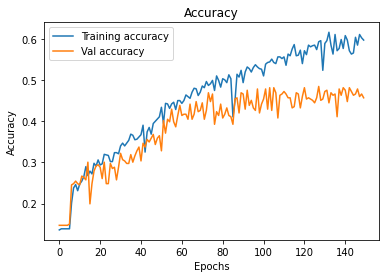

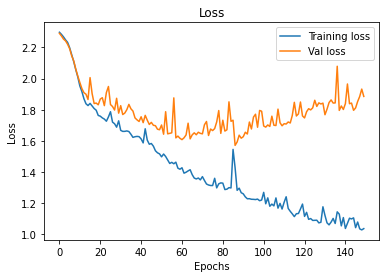

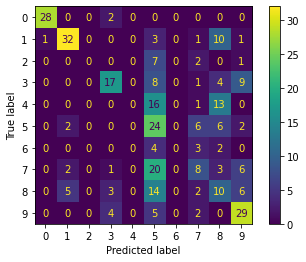

In [ ]:
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")


    x = keras.layers.LSTM(8, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.LSTM(8)(x)
    #x = keras.layers.Dropout(0.3)(x)

    x = keras.layers.Dense(30, activation="relu")(x)
    x = keras.layers.Dense(20, activation="relu")(x)
    x = keras.layers.Dense(10, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=["accuracy"],
    )
    return rnn_model


# Utility for running experiments.
def run_experiment():
    filepath = "/tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1#, monitor="accuracy"
    )

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        #validation_split=0.2,
        validation_data=([test_data[0], test_data[1]], test_labels), 
        epochs=150,
        callbacks=[checkpoint]
    )

   #Plot Graphs
    plt.figure(0)
    plt.plot(history.history['accuracy'], label='Training accuracy')
    plt.plot(history.history['val_accuracy'], label='Val accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.figure(1)
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Val loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    seq_model.summary()

    
    #Experiments Summary
    seq_model.load_weights(filepath)
    model_results = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(model_results[1] * 100, 2)}%")
    print("Test loss:" + str(model_results[0]))
    


    test_pred = seq_model.predict([test_data[0], test_data[1]])
    test_pred = list(np.argmax(test_pred,axis = 1))

   
    #Cohen's Kappa and F1 Score
    ConfusionMatrixDisplay.from_predictions(test_labels, test_pred)

    print("Cohen's Kappa:"+str (cohen_kappa_score(test_labels, test_pred)))
    print(classification_report(test_labels, test_pred))

    return history, seq_model


_, sequence_model = run_experiment()